In [2]:
import os
import math
import string
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder


In [3]:
if tf.test.is_gpu_available():
    # GPU
    BATCH_SIZE = 256  # Number of examples used in each iteration
    EPOCHS = 10  # Number of passes through entire dataset
    MAX_LEN = 170  # Max length of review (in words)
    VOCAB_SIZE = 1000  # Size of vocabulary dictionary
    EMBEDDING = 8  # Dimension of word embedding vector
    
# Hyperparams for CPU training
else:
    # CPU
    BATCH_SIZE = 128
    EPOCHS = 10
    MAX_LEN = 170
    VOCAB_SIZE = 1000
    EMBEDDING = 8

In [7]:


# Convert the data to a Pandas data frame
data = pd.read_csv('winemag-data_first150K.csv')

# Shuffle the data
data = data.sample(frac=1)

# Print the first 5 rows
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
84220,84220,Chile,The opening boasts fresh red-berry aromas and ...,Babor,84,8.0,Central Valley,NaN,NaN,Cabernet Sauvignon,Odfjell
8374,8374,Chile,Simple but friendly aromas of green fruits and...,Select Terroir,86,10.0,Maipo Valley,NaN,NaN,Sauvignon Blanc,Santa Ema
99515,99515,Italy,Opens with a pretty shade of gold that denotes...,Pinot Grigio,86,15.0,Northeastern Italy,Colli Orientali del Friuli,NaN,Pinot Grigio,Mosolo Gleni
56370,56370,France,"89-91 Barrel sample. A smoothly ripe wine, the...",Barrel sample,90,NaN,Bordeaux,Listrac-Médoc,NaN,Bordeaux-style Red Blend,Château Fourcas Dupré
101076,101076,Portugal,"A huge, superrich selection, this was named in...",Monte da Cal Vinha de Saturno,91,28.0,Alentejano,NaN,NaN,Portuguese Red,Dão Sul


In [8]:
data = data[pd.notnull(data['country'])]
data = data[pd.notnull(data['price'])]
data = data.drop(data.columns[0], axis=1) 

variety_threshold = 500 # Anything that occurs less than this will be removed.
value_counts = data['variety'].value_counts()
to_remove = value_counts[value_counts <= variety_threshold].index
data.replace(to_remove, np.nan, inplace=True)
data = data[pd.notnull(data['variety'])]

# Split data into train and test
train_size = int(len(data) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))

Train size: 95647
Test size: 23912


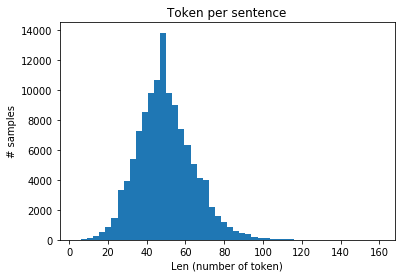

In [9]:
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

# Plot sentence by length
plt.hist([len(tokenize(s)) for s in data['description'].values], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [10]:
description_train = data['description'][:train_size]
variety_train = data['variety'][:train_size]

# Train labels
labels_train = data['price'][:train_size]

# Test features
description_test = data['description'][train_size:]
variety_test = data['variety'][train_size:]

# Test labels
labels_test = data['price'][train_size:]

In [11]:
print("First Original Sample:", data['description'].values[0])
# Create a tokenizer to preprocess our text descriptions
tokenizer = keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, char_level=False)
tokenizer.fit_on_texts(description_train) # only fit on train

# Wide feature 1: sparse bag of words (bow) vocab_size vector 
description_bow_train = tokenizer.texts_to_matrix(description_train)
description_bow_test = tokenizer.texts_to_matrix(description_test)
print("\nFirst Sample after BoW (sparse representation truncated at the first 100 vocabulary terms):", description_bow_train[0][:100])

# Wide feature 2: one-hot vector of variety categories
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(variety_train)
variety_train = encoder.transform(variety_train)
variety_test = encoder.transform(variety_test)
num_classes = np.max(variety_train) + 1

# Convert labels to one hot
variety_train = keras.utils.to_categorical(variety_train, num_classes)
variety_test = keras.utils.to_categorical(variety_test, num_classes)

First Original Sample: The opening boasts fresh red-berry aromas and prickle. Feels racy and energetic, with zesty red-cherry and red-plum flavors. Edgy, jumpy and mostly harmonious, but more tangy than deep, rich or complex.

First Sample after BoW (sparse representation truncated at the first 100 vocabulary terms): [0. 1. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [12]:
bow_inputs = layers.Input(shape=(VOCAB_SIZE,))
variety_inputs = layers.Input(shape=(num_classes,))
merged_layer = layers.concatenate([bow_inputs, variety_inputs])
merged_layer = layers.Dense(256, activation='relu')(merged_layer)
predictions = layers.Dense(1)(merged_layer)
wide_model = keras.Model(inputs=[bow_inputs, variety_inputs], outputs=predictions)

wide_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
print(wide_model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 1040)         0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          266496      concatenate[0][0]            

In [14]:
print("First Original Sample:", data['description'].values[0])

# Deep model feature: word embeddings of wine descriptions
train_embed = tokenizer.texts_to_sequences(description_train)
test_embed = tokenizer.texts_to_sequences(description_test)

train_embed = keras.preprocessing.sequence.pad_sequences(
    train_embed, maxlen=MAX_LEN, padding="post")
test_embed = keras.preprocessing.sequence.pad_sequences(
    test_embed, maxlen=MAX_LEN, padding="post")

print("\nFirst Sample after Preprocessing for Embedding:", train_embed[0])

First Original Sample: The opening boasts fresh red-berry aromas and prickle. Feels racy and energetic, with zesty red-cherry and red-plum flavors. Edgy, jumpy and mostly harmonious, but more tangy than deep, rich or complex.

First Sample after Preprocessing for Embedding: [  2 990 568  47  41  44  20   1 199 529   1   5 353  41  19   1  41  58
   8 996   1 782  14  57 336 122 251  37  64 126   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0]


In [15]:
deep_inputs = layers.Input(shape=(MAX_LEN,))
embedding = layers.Embedding(VOCAB_SIZE, EMBEDDING, input_length=MAX_LEN)(deep_inputs)
embedding = layers.Flatten()(embedding)
embed_out = layers.Dense(1)(embedding)
deep_model = keras.Model(inputs=deep_inputs, outputs=embed_out)
print(deep_model.summary())

deep_model.compile(loss='mse',
                       optimizer='adam',
                       metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 170)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 170, 8)            8000      
_________________________________________________________________
flatten (Flatten)            (None, 1360)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1361      
Total params: 9,361
Trainable params: 9,361
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
merged_out = layers.concatenate([wide_model.output, deep_model.output])
merged_out = layers.Dense(1)(merged_out)
combined_model = keras.Model(wide_model.input + [deep_model.input], merged_out)
print(combined_model.summary())

combined_model.compile(loss='mse',
                       optimizer='adam',
                       metrics=['accuracy'])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1000)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 170)]        0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 1040)         0           input_1[0][0]                    
                                                                 input_2[0][0]              

In [17]:
combined_model.fit([description_bow_train, variety_train] + [train_embed], labels_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)

Epoch 1/10
95647/95647 - 13s - loss: 1306.4074 - accuracy: 0.0000e+00
Epoch 2/10
95647/95647 - 10s - loss: 1068.1601 - accuracy: 0.0000e+00
Epoch 3/10
95647/95647 - 10s - loss: 1035.3221 - accuracy: 0.0000e+00
Epoch 4/10
95647/95647 - 9s - loss: 1000.6569 - accuracy: 0.0000e+00
Epoch 5/10
95647/95647 - 10s - loss: 958.8464 - accuracy: 0.0000e+00
Epoch 6/10
95647/95647 - 10s - loss: 917.2827 - accuracy: 0.0000e+00
Epoch 7/10
95647/95647 - 9s - loss: 873.8539 - accuracy: 0.0000e+00
Epoch 8/10
95647/95647 - 10s - loss: 831.3093 - accuracy: 0.0000e+00
Epoch 9/10
95647/95647 - 9s - loss: 788.3262 - accuracy: 0.0000e+00
Epoch 10/10
95647/95647 - 9s - loss: 745.5497 - accuracy: 0.0000e+00


In [18]:
combined_model.evaluate([description_bow_test, variety_test] + [test_embed], labels_test, batch_size=BATCH_SIZE)

23912/23912 [==============================] - 1s 33us/sample - loss: 794.6553 - accuracy: 0.0000e+00


[794.655252711276, 0.0]

In [19]:
from ipywidgets import interact
from ipywidgets import widgets

def evaluate(num_predictions):
    # Generate predictions
    predictions = combined_model.predict([description_bow_test, variety_test] + [test_embed])

    # Compare predictions with actual values for the first few items in our test dataset
    diff = 0
    for i in range(num_predictions):
        val = predictions[i]
        print('[{}] - {}'.format(i+1, description_test.iloc[i]))
        print('Predicted: ', val[0], 'Actual: ', labels_test.iloc[i], '\n')
        diff += abs(val[0] - labels_test.iloc[i])

    # Compare the average difference between actual price and the model's predicted price
    print('Average prediction difference: ', diff / num_predictions)

interact(evaluate, num_predictions=widgets.IntSlider(value=1, min=1, max=20, description='# of test to evaluate/show'));

interactive(children=(IntSlider(value=1, description='# of test to evaluate/show', max=20, min=1), Output()), …

In [21]:
predictions = combined_model.predict([description_bow_test, variety_test] + [test_embed])

In [23]:
num_prediction=40
diff = 0

for i in range(num_predictions):
    val = predictions[i]
    print(description_test.iloc[i])
    print('Predicted: ', val[0], 'Actual: ', labels_test.iloc[i], '\n')
    diff += abs(val[0] - labels_test.iloc[i])

Plum, black cherry and pepper gives this hearty red a lush start. Round, full flavors of black fruit and spice on the palate are balanced by moderate tannins and good acidity. Pair with game, hearty stews,and grilled steaks.
Predicted:  13.313821 Actual:  14.0 

Lighter than Malibu Oak's Cabernet Sauvignon, this Cab Franc shows the variety's characteristic herby notes and is otherwise easy and light, with enough depth to pair well with a range of meats.
Predicted:  20.277962 Actual:  27.0 

Kind of heavy and dull, with earth and mineral flavors breaking into citrus and green apples. Finishes bone dry and tart in acids. Call it Chablisian.
Predicted:  28.203745 Actual:  32.0 

Practically overflows with lush, ripe fruit—mainly cassis—but that richness is kept in classic balance by the dusty tannins on the finish. This is fuller and creamier than the also impressive St. Helena bottling. 125 cases produced. Drink now–2015.
Predicted:  54.05098 Actual:  100.0 

Herbal peppercorn gives this

# PREDICTIONS

In [25]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import pickle

In [28]:
test_descriptions = [
    'From 18-year-old vines, this supple well-balanced effort blends flavors of mocha, cherry, vanilla and breakfast tea. Superbly integrated and delicious even at this early stage, this wine seems destined for a long and savory cellar life. Drink now through 2028.',
    'The Quarts de Chaume, the four fingers of land that rise above the Layon Valley, are one of the pinnacles of sweet wines in the Loire. Showing botrytis and layers of dryness over the honey and peach jelly flavors, but also has great freshness. The aftertaste just lasts.',
    'Nicely oaked blackberry, licorice, vanilla and charred aromas are smooth and sultry. This is an outstanding wine from an excellent year. Forward barrel-spice and mocha flavors adorn core blackberry and raspberry fruit, while this runs long and tastes vaguely chocolaty on the velvety finish. Enjoy this top-notch Tempranillo through 2030.',
    'Bright, light oak shadings dress up this medium-bodied wine, complementing the red cherry and strawberry flavors. Its fresh, fruity and not very tannic—easy to drink and enjoy.',
    'This wine features black cherry, blackberry, blueberry with aromas of black licorice and earth. Ending with a creamy vanilla finish.'
]

# Enter the corresponding varieties here
test_varieties = [
    'Pinot Noir',
    'Chenin Blanc',
    'Tempranillo',
    'Sauvignon Blanc',
    'Syrah'
]

# Enter the corresponding prices here
labels = [
    48,
    152,
    80,
    10,
    23
]

In [29]:
vocab_lookup = tokenizer.word_index
first_20_words = {k: vocab_lookup[k] for k in list(vocab_lookup)[:20]}
print("Sample vocab\n", first_20_words, "\n")
print("Variety encoder\n", encoder.classes_, "\n")

Sample vocab
 {'and': 1, 'the': 2, 'a': 3, 'of': 4, 'with': 5, 'this': 6, 'is': 7, 'flavors': 8, 'wine': 9, 'in': 10, 'to': 11, 'it': 12, 'fruit': 13, 'but': 14, 'on': 15, 'that': 16, "it's": 17, 'finish': 18, 'cherry': 19, 'aromas': 20} 

Variety encoder
 ['Albariño' 'Barbera' 'Bordeaux-style Red Blend'
 'Bordeaux-style White Blend' 'Cabernet Franc' 'Cabernet Sauvignon'
 'Carmenère' 'Champagne Blend' 'Chardonnay' 'Chenin Blanc'
 'Corvina, Rondinella, Molinara' 'Gewürztraminer' 'Grenache'
 'Grüner Veltliner' 'Malbec' 'Merlot' 'Nebbiolo' 'Petite Sirah'
 'Pinot Grigio' 'Pinot Gris' 'Pinot Noir' 'Port' 'Portuguese Red'
 'Portuguese White' 'Prosecco' 'Red Blend' 'Rhône-style Red Blend'
 'Riesling' 'Rosé' 'Sangiovese' 'Sangiovese Grosso' 'Sauvignon Blanc'
 'Shiraz' 'Sparkling Blend' 'Syrah' 'Tempranillo' 'Tempranillo Blend'
 'Viognier' 'White Blend' 'Zinfandel'] 



In [30]:
vocab_lookup = tokenizer.word_index
first_20_words = {k: vocab_lookup[k] for k in list(vocab_lookup)[:20]}
print("Sample vocab\n", first_20_words, "\n")
print("Variety encoder\n", encoder.classes_, "\n")

Sample vocab
 {'and': 1, 'the': 2, 'a': 3, 'of': 4, 'with': 5, 'this': 6, 'is': 7, 'flavors': 8, 'wine': 9, 'in': 10, 'to': 11, 'it': 12, 'fruit': 13, 'but': 14, 'on': 15, 'that': 16, "it's": 17, 'finish': 18, 'cherry': 19, 'aromas': 20} 

Variety encoder
 ['Albariño' 'Barbera' 'Bordeaux-style Red Blend'
 'Bordeaux-style White Blend' 'Cabernet Franc' 'Cabernet Sauvignon'
 'Carmenère' 'Champagne Blend' 'Chardonnay' 'Chenin Blanc'
 'Corvina, Rondinella, Molinara' 'Gewürztraminer' 'Grenache'
 'Grüner Veltliner' 'Malbec' 'Merlot' 'Nebbiolo' 'Petite Sirah'
 'Pinot Grigio' 'Pinot Gris' 'Pinot Noir' 'Port' 'Portuguese Red'
 'Portuguese White' 'Prosecco' 'Red Blend' 'Rhône-style Red Blend'
 'Riesling' 'Rosé' 'Sangiovese' 'Sangiovese Grosso' 'Sauvignon Blanc'
 'Shiraz' 'Sparkling Blend' 'Syrah' 'Tempranillo' 'Tempranillo Blend'
 'Viognier' 'White Blend' 'Zinfandel'] 



In [31]:
embed_description = tokenizer.texts_to_sequences(test_descriptions)
embed_description = keras.preprocessing.sequence.pad_sequences(
    embed_description, maxlen=170, padding="post")

print(embed_description[0])

[ 24 283 346 505   6 342  55  87 545   8   4 226  19  51   1 367 481   1
 150 232  60   6 878 858   6   9 218  21   3  86   1 242 310  32  38  79
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0]


In [33]:
for i in range(len(test_descriptions)):
    val = predictions[i]
    print(test_descriptions[i])
    print('Predicted: ', val[0], 'Actual: ', labels[i], '\n')

From 18-year-old vines, this supple well-balanced effort blends flavors of mocha, cherry, vanilla and breakfast tea. Superbly integrated and delicious even at this early stage, this wine seems destined for a long and savory cellar life. Drink now through 2028.
Predicted:  13.313821 Actual:  48 

The Quarts de Chaume, the four fingers of land that rise above the Layon Valley, are one of the pinnacles of sweet wines in the Loire. Showing botrytis and layers of dryness over the honey and peach jelly flavors, but also has great freshness. The aftertaste just lasts.
Predicted:  20.277962 Actual:  152 

Nicely oaked blackberry, licorice, vanilla and charred aromas are smooth and sultry. This is an outstanding wine from an excellent year. Forward barrel-spice and mocha flavors adorn core blackberry and raspberry fruit, while this runs long and tastes vaguely chocolaty on the velvety finish. Enjoy this top-notch Tempranillo through 2030.
Predicted:  28.203745 Actual:  80 

Bright, light oak sh